<a href="https://colab.research.google.com/github/jinisaweaklearner/DS-ML-Paper-Note-Code/blob/master/gansynth_external.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [2]:
# Copyright 2019 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# GANSynth Demo

This notebook is a demo *GANSynth*, which generates audio with Generative Adversarial Networks. 
GANSynth learns to produce individual instrument notes like the [NSynth Dataset](https://magenta.tensorflow.org/datasets/nsynth). With pitch provided as a conditional attribute, the generator learns to use its latent space to represent different instrument timbres. This allows us to synthesize performances from MIDI files, either keeping the timbre constant, or interpolating between instruments over time.

* [GANSynth ICLR paper](https://arxiv.org/abs/1809.11096)
* [Audio Examples](http://goo.gl/magenta/gansynth-examples) 


<img src="https://storage.googleapis.com/magentadata/papers/gansynth/figures/models.jpeg" alt="GANSynth figure" width="600">

## 1: Environment Setup


This notebook synthesizes audio from uploaded MIDI files. There are two different flavors:
* Interpolate between random instruments
* Interpolate between two chosen instruments


Have fun! And please feel free to hack this notebook to make your own creative interactions.

### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Then press the **Play** button on the left of each of the cells
* Double-click any of the cells to view the code



In [3]:
#@title Install

#@markdown Install magenta, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.

# Install Magenta
print('Copying data from GCS...')
!rm -r /content/gansynth &>/dev/null
!mkdir /content/gansynth
!mkdir /content/gansynth/midi
!mkdir /content/gansynth/samples

# Get default MIDI (Bach Prelude)
!curl -o /content/gansynth/midi/bach.mid http://www.jsbach.net/midi/cs1-1pre.mid
MIDI_SONG_DEFAULT = '/content/gansynth/midi/bach.mid'
!curl -o /content/gansynth/midi/riff-default.mid http://storage.googleapis.com/magentadata/papers/gansynth/midi/arp.mid
MIDI_RIFF_DEFAULT = '/content/gansynth/midi/riff-default.mid'

!pip install -q -U magenta

import os
from google.colab import files
import librosa
from magenta.models.nsynth.utils import load_audio
from magenta.models.gansynth.lib import flags as lib_flags
from magenta.models.gansynth.lib import generate_util as gu
from magenta.models.gansynth.lib import model as lib_model
from magenta.models.gansynth.lib import util
import matplotlib.pyplot as plt
import note_seq
from note_seq.notebook_utils import colab_play as play
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

# File IO
download = files.download

def upload():
  '''Upload a .wav file.'''
  filemap = files.upload()
  file_list = []
  for key, value in filemap.iteritems():
    fname = os.path.join('/content/gansynth/midi', key)
    with open(fname, 'w') as f:
      f.write(value)
      print('Writing {}'.format(fname))
    file_list.append(fname)
  return file_list

# GLOBALS
CKPT_DIR = 'gs://magentadata/models/gansynth/acoustic_only'
output_dir = '/content/gansynth/samples'
BATCH_SIZE = 16
SR = 16000

# Make an output directory if it doesn't exist
OUTPUT_DIR = util.expand_path(output_dir)
if not tf.gfile.Exists(OUTPUT_DIR):
  tf.gfile.MakeDirs(OUTPUT_DIR)

# Load the model
tf.reset_default_graph()
flags = lib_flags.Flags({
    'batch_size_schedule': [BATCH_SIZE],
    'tfds_data_dir': "gs://tfds-data/datasets",
})
model = lib_model.Model.load_from_path(CKPT_DIR, flags)

# Helper functions
def load_midi(midi_path, min_pitch=36, max_pitch=84):
  """Load midi as a notesequence."""
  midi_path = util.expand_path(midi_path)
  ns = note_seq.midi_file_to_sequence_proto(midi_path)
  pitches = np.array([n.pitch for n in ns.notes])
  velocities = np.array([n.velocity for n in ns.notes])
  start_times = np.array([n.start_time for n in ns.notes])
  end_times = np.array([n.end_time for n in ns.notes])
  valid = np.logical_and(pitches >= min_pitch, pitches <= max_pitch)
  notes = {'pitches': pitches[valid],
           'velocities': velocities[valid],
           'start_times': start_times[valid],
           'end_times': end_times[valid]}
  return ns, notes

def get_envelope(t_note_length, t_attack=0.010, t_release=0.3, sr=16000):
  """Create an attack sustain release amplitude envelope."""
  t_note_length = min(t_note_length, 3.0)
  i_attack = int(sr * t_attack)
  i_sustain = int(sr * t_note_length)
  i_release = int(sr * t_release)
  i_tot = i_sustain + i_release  # attack envelope doesn't add to sound length
  envelope = np.ones(i_tot)
  # Linear attack
  envelope[:i_attack] = np.linspace(0.0, 1.0, i_attack)
  # Linear release
  envelope[i_sustain:i_tot] = np.linspace(1.0, 0.0, i_release)
  return envelope

def combine_notes(audio_notes, start_times, end_times, velocities, sr=16000):
  """Combine audio from multiple notes into a single audio clip.

  Args:
    audio_notes: Array of audio [n_notes, audio_samples].
    start_times: Array of note starts in seconds [n_notes].
    end_times: Array of note ends in seconds [n_notes].
    sr: Integer, sample rate.

  Returns:
    audio_clip: Array of combined audio clip [audio_samples]
  """
  n_notes = len(audio_notes)
  clip_length = end_times.max() + 3.0
  audio_clip = np.zeros(int(clip_length) * sr)

  for t_start, t_end, vel, i in zip(start_times, end_times, velocities, range(n_notes)):
    # Generate an amplitude envelope
    t_note_length = t_end - t_start
    envelope = get_envelope(t_note_length)
    length = len(envelope)
    audio_note = audio_notes[i, :length] * envelope
    # Normalize
    audio_note /= audio_note.max()
    audio_note *= (vel / 127.0)
    # Add to clip buffer
    clip_start = int(t_start * sr)
    clip_end = clip_start + length
    audio_clip[clip_start:clip_end] += audio_note

  # Normalize
  audio_clip /= audio_clip.max()
  audio_clip /= 2.0
  return audio_clip

# Plotting tools
def specplot(audio_clip):
  p_min = np.min(36)
  p_max = np.max(84)
  f_min = librosa.midi_to_hz(p_min)
  f_max = 2 * librosa.midi_to_hz(p_max)
  octaves = int(np.ceil(np.log2(f_max) - np.log2(f_min)))
  bins_per_octave = 36
  n_bins = int(bins_per_octave * octaves)
  C = librosa.cqt(audio_clip, sr=SR, hop_length=2048, fmin=f_min, n_bins=n_bins, bins_per_octave=bins_per_octave)
  power = 10 * np.log10(np.abs(C)**2 + 1e-6)
  plt.matshow(power[::-1, 2:-2], aspect='auto', cmap=plt.cm.magma)
  plt.yticks([])
  plt.xticks([])

print('And...... Done!')

Copying data from GCS...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4922  100  4922    0     0  20767      0 --:--:-- --:--:-- --:--:-- 20767
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1083  100  1083    0     0   6260      0 --:--:-- --:--:-- --:--:--  6260
     |████████████████████████████████| 1.4MB 4.5MB/s 
     |████████████████████████████████| 5.6MB 19.2MB/s 
     |████████████████████████████████| 2.3MB 48.8MB/s 
     |████████████████████████████████| 256kB 51.6MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 358kB 54.5MB/s 
     |████████████████████████████████| 1.5MB 56.6MB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


Instructions for updating:
Use `tf.random.categorical` instead.


Instructions for updating:
Use `tf.random.categorical` instead.


Instructions for updating:
Use keras.layers.Flatten instead.


Instructions for updating:
Use keras.layers.Flatten instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Restoring parameters from gs://magentadata/models/gansynth/acoustic_only/stage_00012/model.ckpt-11000000


INFO:tensorflow:Restoring parameters from gs://magentadata/models/gansynth/acoustic_only/stage_00012/model.ckpt-11000000


And...... Done!


## 2(a): Random Interpolation

These cells take the MIDI for a full song and interpolate between several random latent vectors (equally spaced in time) over the whole song. The result sounds like instruments that slowly and smoothly morph between each other.  

In [4]:
#@title Choose a MIDI file

#@markdown Upload a MIDI file _(.mid, single instrument)_ for audio synthesis, or use the provided default. You can find lots of free MIDI files [online](http://www.midiworld.com/files/).

midi_file = "Upload your own" #@param ["Bach Prelude (Default)", "Upload your own"]

midi_path = MIDI_SONG_DEFAULT
if midi_file == "Upload your own":
  try:
    file_list = upload()
    midi_path = file_list[0]
  except Exception as e:
    print('Upload Cancelled')

ns, notes = load_midi(midi_path)
print('Loaded {}'.format(midi_path))
note_seq.plot_sequence(ns)

Saving Movie_Themes_-_1941.mid to Movie_Themes_-_1941.mid
Upload Cancelled
Loaded /content/gansynth/midi/bach.mid


Generating 656 samples...
generate_samples: generated 656 samples in 17.268100261688232s

Audio:


CQT Spectrogram:


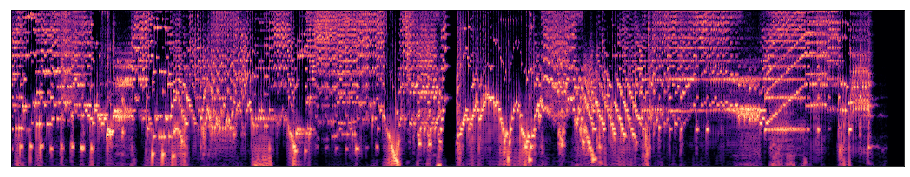

In [5]:
#@title Generate random interpolation 🎵
#@markdown Select the number of seconds to take in interpolating between each random instrument. Larger numbers will have slower and smoother interpolations.

seconds_per_instrument = 3 #@param {type:"slider", min:1, max:10, step:1}

#@markdown This cell plays and displays a [Constant-Q spectrogram](https://en.wikipedia.org/wiki/Constant-Q_transform) of the synthesized audio.

# Distribute latent vectors linearly in time
z_instruments, t_instruments = gu.get_random_instruments(
    model, notes['end_times'][-1], secs_per_instrument=seconds_per_instrument)

# Get latent vectors for each note
z_notes = gu.get_z_notes(notes['start_times'], z_instruments, t_instruments)

# Generate audio for each note
print('Generating {} samples...'.format(len(z_notes)))
audio_notes = model.generate_samples_from_z(z_notes, notes['pitches'])

# Make a single audio clip
audio_clip = combine_notes(audio_notes,
                           notes['start_times'],
                           notes['end_times'],
                           notes['velocities'])

# Play the audio
print('\nAudio:')
play(audio_clip, sample_rate=SR)
print('CQT Spectrogram:')
specplot(audio_clip)



In [6]:
#@title Download 
#@markdown Get the .wav file (optional)

# Write the file
fname = os.path.join(output_dir, 'generated_clip.wav')
gu.save_wav(audio_clip, fname)
download(fname)

Saved to /content/gansynth/samples/generated_clip.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2(b): You Choose the Interpolation

These cells allow you to choose two latent vectors and interpolate between them over a MIDI clip.

In [ ]:
#@title Choose a MIDI file

#@markdown Upload a MIDI file _(.mid, single instrument)_ for audio synthesis, or use the provided default.

midi_file = "Arpeggio (Default)" #@param ["Arpeggio (Default)", "Upload your own"]

midi_path = MIDI_RIFF_DEFAULT
if midi_file == "Upload your own":
  try:
    file_list = upload()
    midi_path = file_list[0]
    ns, notes_2 = load_midi(midi_path)
  except Exception as e:
    print('Upload Cancelled')
else:
  # Load Default, but slow it down 30%
  ns, notes_2 = load_midi(midi_path)
  notes_2['start_times'] *= 1.3
  notes_2['end_times'] *= 1.3


print('Loaded {}'.format(midi_path))
note_seq.plot_sequence(ns)

In [ ]:
#@title Sample some random instruments

number_of_random_instruments = 10 #@param {type:"slider", min:4, max:16, step:1}
pitch_preview = 60
n_preview = number_of_random_instruments

pitches_preview = [pitch_preview] * n_preview
z_preview = model.generate_z(n_preview)

audio_notes = model.generate_samples_from_z(z_preview, pitches_preview)
for i, audio_note in enumerate(audio_notes):
  print("Instrument: {}".format(i))
  play(audio_note, sample_rate=16000)



In [ ]:
#@title Generate custom interpolation 🎵
##@markdown Using the instrument numbers from the cell above, pick two instruments to interpolate between over the clip.

#@markdown Using the instrument numbers from the cell above, create a list of instruments to interpolate between. You can repeat instruments.

instruments = [0, 2, 4, 0] #@param

#@markdown For each instrument in the list above, place it at a relative time [0-1.0] in the clip. __The list of times must _always increase_ and start at 0 and end at 1.0__.

times = [0, 0.3, 0.6, 1.0] #@param

# Force endpoints
times[0] = -0.001
times[-1] = 1.0

#@markdown This cell plays and displays a [Constant-Q spectrogram](https://en.wikipedia.org/wiki/Constant-Q_transform) of the synthesized audio.

z_instruments = np.array([z_preview[i] for i in instruments])
t_instruments = np.array([notes_2['end_times'][-1] * t for t in times])

# Get latent vectors for each note
z_notes = gu.get_z_notes(notes_2['start_times'], z_instruments, t_instruments)

# Generate audio for each note
print('Generating {} samples...'.format(len(z_notes)))
audio_notes = model.generate_samples_from_z(z_notes, notes_2['pitches'])

# Make a single audio clip
audio_clip = combine_notes(audio_notes,
                           notes_2['start_times'],
                           notes_2['end_times'],
                           notes_2['velocities'])

# Play the audio
print('\nAudio:')
play(audio_clip, sample_rate=SR)
print('CQT Spectrogram:')
specplot(audio_clip)


In [ ]:
#@title Download
#@markdown Get the .wav file (optional)

# Write the file
fname = os.path.join(output_dir, 'generated_clip.wav')
gu.save_wav(audio_clip, fname)
download(fname)